In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [2]:

X_train = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train_scaled.csv')
X_cv = pd.read_csv('X_val_scaled.csv')
y_cv = pd.read_csv('y_val_scaled.csv')
X_train_cv = pd.read_csv('X_train_val_scaled.csv')
y_train_cv = pd.read_csv('y_train_val_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test_scaled.csv')

 ## Defining LSTM Model & MAPE Functions

In [3]:
def run(batchSize, numEpochs, X, Y, pred_set, actual_set):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)

    orig = actual_set

    rmse = sqrt(mean_squared_error(orig, predicted_Price))
    mape = get_mape(orig, predicted_Price)
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [4]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [5]:
# vary training batches
param_label = 'epochs'
param_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32

for param in param_list:
    rmse, mape = run(default_batch_size, param, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/500


2022-04-27 16:37:05.846597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 1ms/step - loss: 0.5280
Epoch 2/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3077
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2154
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1699
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1304
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0993
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0771
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0611
Epoch 9/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 10/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 11/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 12/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 13/500
14/14 [=============================

,epochs,rmse,mape
0,500,0.400114,41.268025
1,1000,0.721357,82.595197
2,1500,0.309033,31.810137
3,2000,0.363954,33.294558
4,2500,0.454422,51.072175
5,3000,0.541043,50.204241
6,3500,0.355646,35.582812
7,4000,0.644570,64.045311
8,4500,0.555774,52.885205
9,5000,0.521836,61.237567


In [6]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 0.309
optimum params = 1500


In [7]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 31.810%
optimum params = 1500


## Tuning Batch Size Parameter

In [8]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(param, epoch_opt, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/1500
14/14 [==============================] - 1s 1ms/step - loss: 0.5755
Epoch 2/1500
14/14 [==============================] - 0s 1ms/step - loss: 0.3234
Epoch 3/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.2051
Epoch 4/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.1681
Epoch 5/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.1408
Epoch 6/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.1142
Epoch 7/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 8/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.0806
Epoch 9/1500
14/14 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 10/1500
14/14 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 11/1500
14/14 [======

,batch_size,rmse,mape
0,32,0.440365,48.283692
1,64,0.272043,27.038896
2,128,0.290125,28.608846
3,256,0.370756,35.644346


In [9]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 0.272
optimum params = 64


In [10]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 27.039%
optimum params = 64


## Model with Optimal Parameters

In [11]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [12]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs = epoch_opt, batch_size = batch_size_opt, verbose=1, shuffle=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/1500
10/10 [==============================] - 1s 2ms/step - loss: 0.8473
Epoch 2/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.5303
Epoch 3/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.3541
Epoch 4/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.2656
Epoch 5/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.2258
Epoch 6/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.1912
Epoch 7/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 8/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.1352
Epoch 9/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.1169
Epoch 10/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 11/1500
10/10 [======

In [13]:
# LSTM Prediction
y_pred = lstm.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = get_mape(y_test, y_pred)

# Calculate RMSE
print("RMSE on train set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on train set = %0.3f%%" % mape)

RMSE on train set = 0.204
MAPE on train set = 13.659%


In [14]:
X_test

array([[[-0.4165986 ,  1.71250294,  1.7875334 , ...,  0.29271302,
          0.47640873,  0.21768313]],

       [[-0.4165986 ,  1.69715058,  2.75287559, ..., -0.51018981,
         -0.21903377, -1.08460307]],

       [[-0.4165986 ,  1.84890711,  3.33121021, ...,  0.9872895 ,
          1.01218783,  0.60547011]],

       ...,

       [[-0.55438962,  1.07658239,  4.03527645, ..., -0.22147178,
         -0.03571401, -1.4803278 ]],

       [[-1.23279787,  1.14404415,  3.00493077, ..., -0.36710952,
          0.07016988, -1.30002736]],

       [[-0.90631132,  1.11533345,  2.10300893, ..., -1.13453422,
         -0.95315038, -2.46065515]]])

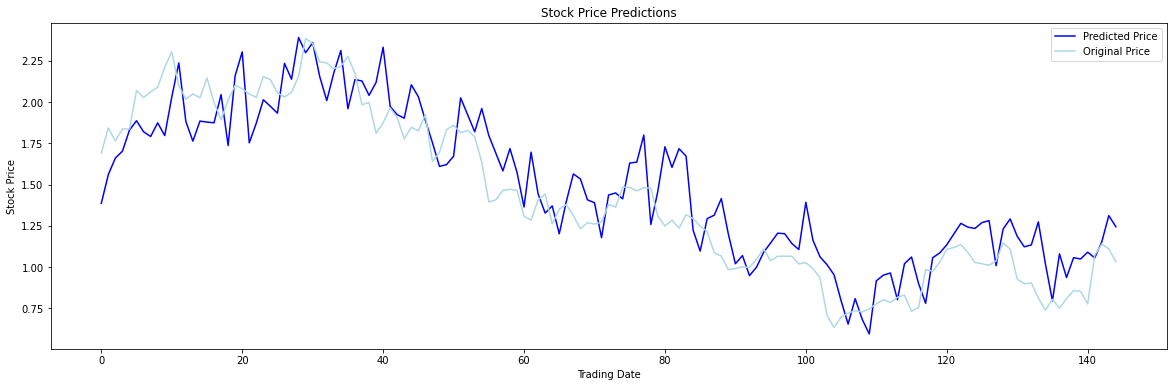

In [15]:
plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
plt.plot(y_test, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Prediction

In [16]:
predict_feature = pd.read_csv('predict_feature.csv')
testX

array([[-0.4165986 ,  1.71250294,  1.7875334 , ...,  0.29271302,
         0.47640873,  0.21768313],
       [-0.4165986 ,  1.69715058,  2.75287559, ..., -0.51018981,
        -0.21903377, -1.08460307],
       [-0.4165986 ,  1.84890711,  3.33121021, ...,  0.9872895 ,
         1.01218783,  0.60547011],
       ...,
       [-0.55438962,  1.07658239,  4.03527645, ..., -0.22147178,
        -0.03571401, -1.4803278 ],
       [-1.23279787,  1.14404415,  3.00493077, ..., -0.36710952,
         0.07016988, -1.30002736],
       [-0.90631132,  1.11533345,  2.10300893, ..., -1.13453422,
        -0.95315038, -2.46065515]])

In [17]:
# Process the data for LSTM
testX =np.array(predict_feature)
predict_feature = testX.reshape(predict_feature.shape[0], 1, predict_feature.shape[1])
predict_feature

array([[[-0.79500295,  0.99478636,  2.69379289, -0.91053679,
          0.30621419,  0.71920306, -0.32882933, -0.16651058,
         -1.43744719, -0.72267876,  0.94996311,  2.80817493,
         -0.91092801,  0.37921589,  0.64249732, -0.52598084,
         -0.24997117, -1.61802785, -0.75104984,  0.88965262,
          3.2483529 , -0.98726414,  0.59240154,  0.57416853,
         -0.66192609, -0.33907478, -1.78608512, -0.86170985,
          0.8319429 ,  2.8508659 , -0.91046227,  0.56229217,
          0.52108076, -0.81476911, -0.49192647, -1.90525532,
         -0.77804137,  0.84418974,  2.78690145, -1.02213244,
          0.67478063,  0.56252312, -0.65679442, -0.36023371,
         -1.62136398]]])

In [18]:
predicted_price = lstm.predict(predict_feature)

In [19]:
predicted_price[0][0]

1.1489661

Reality: Bitcoin currency had a close price of USD 39,137.61 on 4 Mar 2022.

Prediced: Our model predicted the currency to have a close price of USD 46186.727 on 4 Mar 2022.